# Linear Regression

## Modèle explicatif

On a observé deux ensembles de var X et Y sur n individus tel que $y = f(x) + \epsilon$

On suppose que $f$ est une fonction lineaire égale à: $f: x \mapsto ax + b$

### Différences avec l'ACP

Dans une ACP, les variables n'ont pas de relation entre elles.
Ici, y dépend de x.

### Critère des moindres carrées

Le résidu ($e_i = y_i - \hat{y}_i$) correspond à ce qui n'est pas expliqué par le modèle. On cherche à le minimiser.

On va chercher à a et b en minimisant le carré des résidus, c'est-à-dire:

$
\min \sum_i e^2_i = \min \sum_i (y_i - \hat{y}_i)^2
$

La solution optimale donne:

$
b = \frac {\sum (x_i - \overline{x})(y_i - \overline{y})}{\sum (x_i - \overline{x})^2}
b = \frac {cov(x,y)}{var(x)}
$

$
a = \overline{y} - b \overline{x}
$

In [1]:
# Iris dataset
!ls iris.data || wget https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data

iris.data


In [2]:
import pandas as pd
df = pd.read_csv("iris.data", header=None, names=["sepal length", "sepal width", "petal length", "petal width", "class"])
df = df[df["class"] == "Iris-setosa"]
df.describe()

,sepal length,sepal width,petal length,petal width
count,50.00000,50.000000,50.000000,50.00000
mean,5.00600,3.418000,1.464000,0.24400
std,0.35249,0.381024,0.173511,0.10721
min,4.30000,2.300000,1.000000,0.10000
25%,4.80000,3.125000,1.400000,0.20000
50%,5.00000,3.400000,1.500000,0.20000
75%,5.20000,3.675000,1.575000,0.30000
max,5.80000,4.400000,1.900000,0.60000


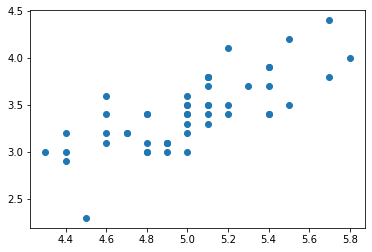

In [3]:
import matplotlib.pyplot as plt
X = df["sepal length"]
y = df["sepal width"]
plt.scatter(X, y)

In [4]:
import numpy as np
X_ = np.average(X)
y_ = np.average(y)
cov_Xy = np.sum((X - X_) * (y - y_))
var_x = np.sum((X - X_) ** 2)
a = cov_Xy / var_x
b = y_ - a * X_
(a, b)

(0.807233665122696, -0.623011727604216)

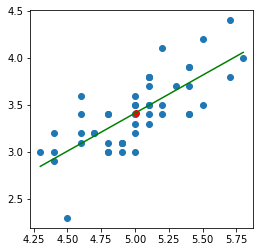

In [5]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X, y)
X_test = np.array([np.min(X), np.max(X)])
y_test = a * X_test + b
ax.plot(X_test, y_test, color="green")
ax.scatter(X_, y_, color="red")

### Propriétés

 - La droite passe par ($\overline{x}$, $\overline{y}$)
 - $\overline{y} = \hat{\overline{y}}$ (moyenne des y = moyenne des y prédits)
 - $\sum e_i = 0$
 - $\sum e_i x_i = 0$
 
### Qualité de l'ajustement linéaire

$
\underbrace{\sum (y_i - \overline{y})^2}_{\text{Somme des carrés totaux}} = \underbrace{\sum (y_i - \hat{y}_i)^2}_{\text{Somme des carrés des résidus/information non expliquée}} + \underbrace{\sum (\hat{y}_i)^2 - \overline{y})^2}_{\text{Somme des carrés/information expliquée par le modèle, par la droite}}
$

### Coefficient de détermination

$
R^2 = \frac{SCE}{SCT} = \frac {\sum (\hat{y}_i)^2 - \overline{y})^2}{\sum (y_i - \overline{y})^2} = b^2 \frac{s^2_x}{s^2_y} = (cor(x, y)) ^2
$

R² mesure l'ajustement de la droite aux données. R² explique la part de variation de y expliquée par la variation de x

## Etude des points influents et des résidus
### Contribution de chaque observation

**Levier** : Contribution d'un point à la construction de la droite
$
h_i = \frac{1}{n} + \frac{(x_i - \overline{x})^2}{\sum (x_j - \overline{x})^2}
$

$h_i$ important is $\gt \frac {4}{n}$. Le levier indique une _potentielle_ influence par rapport à la pente. Pas d'influence => si on retire le point, elle n'impacte pas la droite

Un point abberant (éloigné de la droite) mais pas influent (proche de la moyenne) aura un levier faible => influence sur la distance de Cook faible = levier faible * résidu important

 - Influence en général: **Distance de Cook** pour l'observation i = $D_i = \frac {\hat{y_j} - \hat{y}_{(-i)j}} {2 \hat{\sigma}^2} = \underbrace {\frac{(e_i)^2}{\hat{\sigma}^2}}_{\text{résidu studentisé, influence / y}} \underbrace {\frac {h_i} {(1-h_i)^2}}_{\text{fonction du levier, influence / x}}$
 - Influence variabilité: **Cov Ratio**. Grand si |CovRatio - 1| >3 (P+1)/2
 - Influence prédiction: **DFFITS**. Grand si > 2 * sqrt(P+1) / n
 - Influence pente: **DFBETAS_x**. Grand si |DFBETAS| > 2 / sqrt(n)
 - Influence ordonnée à l'origine: **DFBETAS_intercept** 

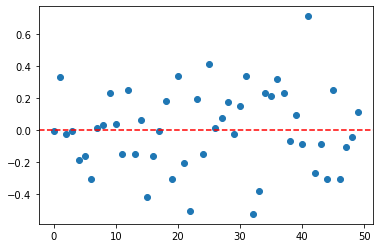

In [6]:
ŷ = a * X + b
residuals = (ŷ - y)
plt.scatter(range(len(residuals)), residuals)
plt.axhline(y = 0, color = 'r', linestyle = 'dashed')

In [7]:
import statsmodels.api as sm
res = sm.OLS(X, y).fit()

infl = res.get_influence()
iris_desc = pd.DataFrame(zip(
    infl.resid_std,
    infl.resid_studentized,
    infl.cooks_distance[0],
    infl.hat_matrix_diag,
    infl.cov_ratio,
    infl.dffits[0],
    infl.dfbetas.reshape((50,))), columns=[
    "StdDev Residual",
    "Student Residual",
    "Cook distance",
    "Hat Diag H",
    "Cov Ratio",
    "Dffits",
    "Dfbetas"
])
iris_desc.head()

,StdDev Residual,Student Residual,Cook distance,Hat Diag H,Cov Ratio,Dffits,Dfbetas
0,0.371363,0.017466,0.000006,0.020719,1.042425,0.002514,0.002514
1,0.372404,1.434280,0.031798,0.015222,0.993093,0.180317,0.180317
2,0.372007,0.115786,0.000236,0.017319,1.038541,0.015216,0.015216
3,0.372209,0.238044,0.000936,0.016254,1.036500,0.030302,0.030302
4,0.371135,-0.644085,0.009297,0.021920,1.034875,-0.095839,-0.095839


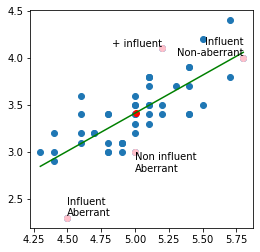

In [8]:
fig, ax = plt.subplots(figsize=(4,4))
ax.scatter(X, y)
X_test = np.array([np.min(X), np.max(X)])
y_test = a * X_test + b
ax.plot(X_test, y_test, color="green")
ax.scatter(X_, y_, color="red")

points = [
    (41, 'Influent\nAberrant', 'left', 'bottom'),
    (14, 'Influent\nNon-aberrant', 'right', 'bottom'),
    (25, 'Non influent\nAberrant', 'left', 'top'),
    # index_point == 32
    (np.argmax(iris_desc["Cook distance"]), '+ influent', 'right', 'bottom'),
]

for index_point, text, ha, va in points:
    xp, yp = X[index_point], y[index_point]
    ax.scatter(xp, yp, color="pink")
    ax.text(xp, yp, text, ha=ha, va=va)

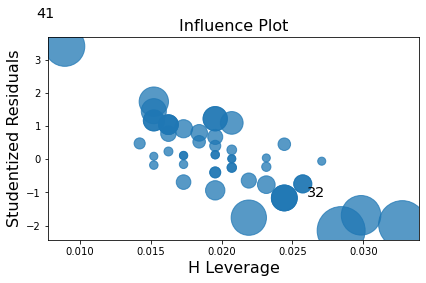

In [9]:
fig = sm.graphics.influence_plot(res, criterion="cooks")
fig.tight_layout(pad=1.0)

#### Reference

 - https://online.stat.psu.edu/stat462/node/173/
 - https://blogs.sas.com/content/iml/2019/06/19/influence-regression-dffits-cooksd.html
 - https://www.kaggle.com/code/kmaingleung/use-cooks-disatnce-dffits-for-outlier-detection


## Aspects inférentiels

### Modèle de regression simple

Soit ($X_i$, $y_i$), un **échantillon** de n individus issues de la population décrite par:
$
y_i = \underbrace{Y / x_i}_{\text{Loi Y conditionné à x_i (connu)}} = \alpha x_i + \beta + \epsilon_i
$

α et β sont des constantes inconnues. On va construire deux estimateurs A et B à partir de l'échantillon. La solutions du système des équations normales donne les estimateurs des moindres carrés des paramètres α et β

$
A \sim \mathcal{N}(a, \frac{\sigma^2}{\sum (x_i - \overline{x})^2}) \\
B \sim \mathcal{N}(b, \sigma^2 \left [ \frac{1}{n} + \frac{\overline{x}}{\sum (x_i - \overline{x})^2} \right ])
$

Estimateur sans biais de la variance des erreurs $\sigma^2 = \frac{1}{n-2} \sum (\hat{y}_i - y_i)^2$

#### Hypothèses

 * $E(epsilon_i)=0$ : évite un biais systématique
 * $V(epsilon_i)=\sigma^2$ : hypothèse d'homoscécadicité
 * $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$: hypothèse de normalité des erreurs => $y_i \sim \mathcal{N}(\alpha x_i + \beta, \sigma^2)$ 
 * $\epsilon_i$ identiques et indépendamment distribués (iid) <=> $\forall i \ne j, cov(\epsilon_i, \epsilon_j) = 0$
 

In [10]:
(a, np.var(residuals) / 48)

(0.807233665122696, 0.0013110705955783326)

In [11]:
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:           sepal length   R-squared (uncentered):                   0.995
Model:                            OLS   Adj. R-squared (uncentered):              0.994
Method:                 Least Squares   F-statistic:                              8892.
Date:                Thu, 22 Dec 2022   Prob (F-statistic):                    4.54e-57
Time:                        11:17:31   Log-Likelihood:                         -21.436
No. Observations:                  50   AIC:                                      44.87
Df Residuals:                      49   BIC:                                      46.79
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
sepal width     1.4553      0.015     94.295      0.000       1.424       1.486
==============================================================================
Omnibus:                        1.351   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.509   Jarque-Bera (JB):                0.599
Skew:                           0.131   Prob(JB):                        0.741
Kurtosis:                       3.468   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""